# 빅콘테스트 - NSSHOP+

## Vision  
판매실적 예측을 통한 편성 최적화 방안(모형) 도출

## Mission  
1. 편성데이터(NS홈쇼핑) 를 활용하여 방송편성표에 따른 판매실적을 예측  
2. 최적 수익을 고려한 요일별/ 시간대별 / 카테고리별 편성 최적화 방안(모형) 제시


기본 정보 1 - 취급액 = 판매단가 * 주문량 (취소, 반품 제외)  
기본 정보 2 - ~19년 10월 : 06:00 ~ 익일 02:00   
기본 정보 3 - 19년 11월~ : 06:20 ~ 익일 02:20  
기본 정보 4 - 예측 기간인 20년 6월 편성표는 월~토 06:20 ~ 02:20(익일), 일요일은 06:20 ~ 02:00로 구성 (심야시간대 제외) <-- ?  
기본 정보 5 - 편성 시간 : 10분 ~ 60분  
  
추정 제외 사항 1 - 토요일 18:00~18:20(+-20) ※ 정보방송시간  
추정 제외 사항 2 - 판매단가 = 0 (무형) 상품  
  
참고사항 1 - 1월 1일 = 화요일  

## 패키지 Import

In [1]:
import pandas as pd
import numpy as np
import datetime
from BIGCON import DataProcessing as dp
import re
from BIGCON import WordPre as wp

## 데이터 전처리  
1. 실적 데이터 (방송일시 DATETIME, 노출 FILLNA, 상품군 One-Hot-Vector, 시청률)
2. 시청률 데이터 
3. 예측 데이터 (방송일시 DATETIME, 노출 FILLNA, 상품군 One-Hot-Vector, 시청률)

In [2]:
performance_df = pd.read_csv(r'datas\train_data\performance.csv')

In [3]:
# DATETIME으로 변경
performance_df = dp.date_change(performance_df, '방송일시')
# 노출시간 채우기, 형변환 (int)
performance_df['노출(분)'].fillna(method='pad', inplace=True)
performance_df['노출(분)'] = performance_df['노출(분)'].astype(int)

In [4]:
# 날짜 그룹화
START_DATE = datetime.datetime(2019, 1, 1, 4)
def change_index(x):
    a = x - START_DATE
    return a.days
performance_df['DAY'] = performance_df['방송일시'].apply(change_index)

In [5]:
# 취급액 Null 0 채우기, 형변환 (int)
performance_df['취급액'].fillna(0, inplace=True)
performance_df['취급액'] = performance_df['취급액'].astype(int)

In [6]:
import matplotlib.pyplot as plt
# plt.plot(performance_df.groupby('DAY').sum()['취급액'])
# performance_df.groupby('DAY').sum()

In [7]:
watch_rating_df = pd.read_csv(r'datas\train_data\view_rating.csv')

In [8]:
# 평균 로우, 칼럼 제거
watch_rating_df.drop(len(watch_rating_df)-1, axis=0, inplace=True)
watch_rating_df.drop(watch_rating_df.columns[-1], axis=1, inplace=True)

# 시간대 Index화
watch_rating_df.set_index('시간대', inplace=True)
watch_rating_df.sort_index(inplace=True)

# 값이 없는 곳은 평균 값으로 채우기
temp = watch_rating_df.mean(axis=1)
for c in watch_rating_df.columns:
    watch_rating_df[c] = temp
watch_rating_df['2020-01-01'] = temp
# 06/30 까지 채우기
for i in range(1, 31):
    watch_rating_df['2020-06-{:02d}'.format(i)] = temp
watch_rating_df['2020-07-01'] = temp

In [9]:
# 1열로 활용가능하게 만들기
total_date = watch_rating_df.columns
total_time = watch_rating_df.index
temp = []
for this_date in total_date:
    for this_time in total_time:
        temp.append(('%s %s'%(this_date, this_time), watch_rating_df[this_date][this_time]))

In [10]:
view_df = dp.date_change(pd.DataFrame(temp, columns = ['date', 'rate']), 'date')
view_df.set_index('date', inplace=True)

In [11]:
temp = list(map(lambda i : sum(view_df['rate'][i['방송일시'] : i['방송일시'] + datetime.timedelta(minutes=int(i['노출(분)']))]), performance_df.iloc))

In [12]:
performance_df['view'] = temp

In [13]:
dp.make_feature(performance_df, '상품군')

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,DAY,view,...,잡화,의류,건강기능,생활용품,주방,농수축,이미용,가전,침구,속옷
0,2019-01-01 06:00:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,0,0.042641,...,0,1,0,0,0,0,0,0,0,0
1,2019-01-01 06:00:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000,0,0.042641,...,0,1,0,0,0,0,0,0,0,0
2,2019-01-01 06:20:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000,0,0.040921,...,0,1,0,0,0,0,0,0,0,0
3,2019-01-01 06:20:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000,0,0.040921,...,0,1,0,0,0,0,0,0,0,0
4,2019-01-01 06:40:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000,0,0.047507,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38304,2020-01-01 00:20:00,20,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,0,364,0.109378,...,0,0,0,0,0,0,0,0,0,0
38305,2020-01-01 00:40:00,20,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,0,364,0.112038,...,0,0,0,0,0,0,0,0,0,0
38306,2020-01-01 01:00:00,20,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,0,364,0.100085,...,0,0,0,0,0,0,0,0,0,0
38307,2020-01-01 01:20:00,20,100490,201478,더케이 예다함 상조서비스(티포트),무형,0,0,364,0.093715,...,0,0,0,0,0,0,0,0,0,0


In [14]:
evaluation_df = pd.read_csv(r'datas\evaluation_data\evaluation.csv')

In [15]:
evaluation_df

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2020-06-01 6:20,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
1,2020-06-01 6:40,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
2,2020-06-01 7:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
3,2020-06-01 7:20,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN
4,2020-06-01 7:40,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN
...,...,...,...,...,...,...,...,...
2886,2020-07-01 0:20,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2887,2020-07-01 0:40,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2888,2020-07-01 1:00,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2889,2020-07-01 1:20,20.0,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN


In [16]:
# DATETIME으로 변경
evaluation_df = dp.date_change(evaluation_df, '방송일시')
# 노출시간 채우기, 형변환 (int)
evaluation_df['노출(분)'].fillna(method='pad', inplace=True)
evaluation_df['노출(분)'] = evaluation_df['노출(분)'].astype(int)

In [17]:
# 날짜 그룹화
START_DATE = datetime.datetime(2020, 6, 1, 4)
def change_index(x):
    a = x - START_DATE
    return a.days
evaluation_df['DAY'] = evaluation_df['방송일시'].apply(change_index)

In [18]:
temp = list(map(lambda i : sum(view_df['rate'][i['방송일시'] : i['방송일시'] + datetime.timedelta(minutes=int(i['노출(분)']))]), evaluation_df.iloc))
evaluation_df['view'] = temp

In [19]:
dp.make_feature(evaluation_df, '상품군')

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,DAY,view,...,잡화,의류,건강기능,생활용품,주방,농수축,이미용,가전,침구,속옷
0,2020-06-01 06:20:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,0,0.040921,...,0,1,0,0,0,0,0,0,0,0
1,2020-06-01 06:40:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,0,0.047507,...,0,1,0,0,0,0,0,0,0,0
2,2020-06-01 07:00:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,0,0.046433,...,0,1,0,0,0,0,0,0,0,0
3,2020-06-01 07:20:00,20,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,0,0.053751,...,0,0,0,0,0,0,0,0,0,1
4,2020-06-01 07:40:00,20,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,0,0.073058,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,2020-07-01 00:20:00,20,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN,29,0.109378,...,0,0,0,0,0,0,0,0,0,0
2887,2020-07-01 00:40:00,20,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN,29,0.112038,...,0,0,0,0,0,0,0,0,0,0
2888,2020-07-01 01:00:00,20,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN,29,0.100085,...,0,0,0,0,0,0,0,0,0,0
2889,2020-07-01 01:20:00,20,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN,29,0.093715,...,0,1,0,0,0,0,0,0,0,0


## 기상 데이터
1. 지역 별 구름 데이터
2. 지역 별 기온 데이터

In [20]:
# 3일 예보
cloud_df = pd.read_csv(r'datas\external_data\cloud_forecast_기상청.csv', index_col=0)
tem_df = pd.read_csv(r'datas\external_data\tem_forecast_기상청.csv', index_col=0)

In [21]:
cloud_df

,standard,forecast,지역,예보,강수확률(%),popul
0,2018-12-24,2018-12-27,서울.인천.경기,구름조금,0.0,25925799
1,2018-12-24,2018-12-27,충청북도,구름조금,0.0,1600007
2,2018-12-24,2018-12-27,충청남도,구름많음,0.0,2123709
3,2018-12-24,2018-12-27,강원영서,구름조금,0.0,770751
4,2018-12-24,2018-12-27,강원영동,구름조금,0.0,770751
...,...,...,...,...,...,...
4990,2020-06-30,2020-07-03,강원영동,구름많음,20.0,770751
4991,2020-06-30,2020-07-03,전라북도,구름많음,30.0,1818917
4992,2020-06-30,2020-07-03,전라남도,구름많음,30.0,1868745
4993,2020-06-30,2020-07-03,경상북도,구름많음,30.0,2665836


In [22]:
weather_cate = {'맑음' :0, '구름조금' : 1, '구름많음' :2, '흐림' :3, '구름많고 눈' :4, '흐리고 눈' :7, '구름많고 비': 5, '흐리고 비' :8, '구름많고 비/눈' :6, '흐리고 비/눈' :9}
cloud_df['wc'] = cloud_df['예보'].apply(lambda i : weather_cate[i])
cloud_df[cloud_df['standard']>'2019-04-30'][['wc','강수확률(%)']].corr(method='pearson')

# 인구수에 따라 날씨 상태 수치화
temp = cloud_df['popul'].unique().sum()
cloud_df['p*wc'] = cloud_df['popul'] / temp  * cloud_df['wc']

train_pwc = list(cloud_df.groupby('forecast').mean()['p*wc'][5:370])
test_pwc = list(cloud_df.groupby('forecast').mean()['p*wc'][522:-3])

In [23]:
# 2019 인구수 TOP 7 주요 도시 선정한 것 (PPT에 추가)
temp = tem_df['popul'].unique().sum()
tem_df['p*lowtem'] = tem_df['popul'] / temp * tem_df['최저기온']
tem_df['p*hightem'] = tem_df['popul'] / temp * tem_df['최고기온']

# 예측 일자 별 최저 기온, 최고 기온 추가
train_plowtem = list(tem_df.groupby('예보시각').mean()['p*lowtem'][1:366])
train_phightem = list(tem_df.groupby('예보시각').mean()['p*hightem'][1:366])

test_plowtem = list(tem_df.groupby('예보시각').mean()['p*lowtem'][369:-3])
test_phightem = list(tem_df.groupby('예보시각').mean()['p*hightem'][369:-3])

## LSTM 취급액 예측
(Time Sequence = 7 days)

### Train Data 생성

In [24]:
train_df = performance_df.groupby('DAY').sum()


# 기상 데이터 추가
train_df['pwc'] = train_pwc
train_df['plowtem'] = train_plowtem
train_df['phightem'] = train_phightem

norm_df = train_df.describe()
#Target Mean, Target Std 고정
target_mean, target_std = train_df.describe()['취급액'][['mean','std']]

for c in train_df.columns:
    dp.normalize(train_df, c, norm_df)

co = train_df.columns[6:]

y_train = train_df['취급액'].values
X_train = np.concatenate((np.asarray(train_df['판매단가']).reshape(365,1,1), np.asarray(train_df[co]).reshape(365,15,1)), axis=1)

X_train.shape, y_train.shape

((365, 16, 1), (365,))

### Test Data 생성

In [25]:
test_df = evaluation_df.groupby('DAY').sum()

test_df['pwc'] = test_pwc
test_df['plowtem'] = test_plowtem
test_df['phightem'] = test_phightem


for c in test_df.columns:
    dp.normalize(test_df, c, norm_df)

X_test = np.concatenate((np.asarray(test_df['판매단가']).reshape(30,1,1), np.asarray(test_df[co]).reshape(30,15,1)), axis=1)
X_test.shape

(30, 16, 1)

In [26]:
# 모델링
from keras.models import Sequential
from keras.layers import LSTM, Dense

model_LSTM = Sequential()
model_LSTM.add(LSTM(100, input_shape=(16, 1)))
model_LSTM.add(Dense(1, activation="linear"))
model_LSTM.compile(loss='mse', optimizer='adam')

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


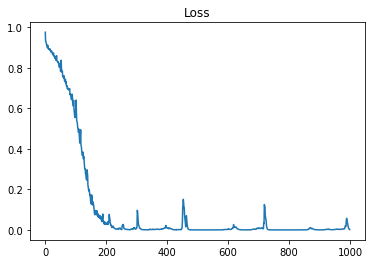

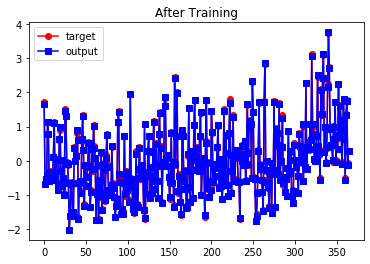

In [27]:
# 시각화
import matplotlib.pyplot as plt

history_LSTM = model_LSTM.fit(X_train, y_train, epochs=1000,verbose=0)
# Loss Graph
plt.plot(history_LSTM.history["loss"])
plt.title("Loss")
plt.show()
# 예측, 실제 값
plt.plot(y_train[:], 'ro-', label="target")
plt.plot(model_LSTM.predict(X_train[:, :, :]), 'bs-', label="output")
plt.legend()
plt.title("After Training")
plt.show()

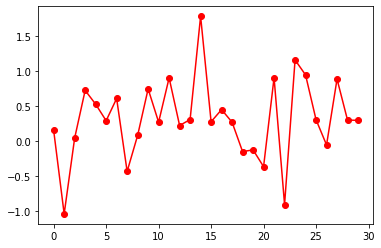

In [28]:
y_pred = model_LSTM.predict(X_test)
plt.plot(y_pred[:], 'ro-', label="target")

In [29]:
real_y = y_pred * target_std + target_mean

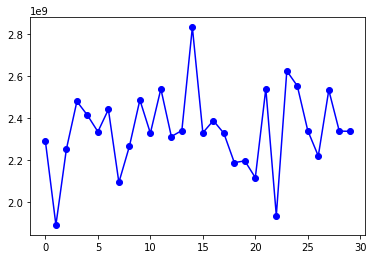

In [30]:
plt.plot(real_y[:], 'bo-', label="target")

## 상품명 토큰화

In [31]:
# 텍스트 전처리 작업

performance_df['상품명'] = performance_df['상품명'].apply(lambda i : re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]',' ', i))

import itertools
temp = list(itertools.chain(*[i.split() for i in list(map(wp.sent_spacing ,performance_df.sort_values('상품명')['상품명']))]))

import nltk
result = nltk.FreqDist(temp)

KeyError: '상품명'

In [ ]:
pd.DataFrame([result.keys(), result.values()]).T.sort_values(1, ascending=False).head(45) # 0, 1 제외하는게 낫지않을라나

In [ ]:
top_tokens = list(pd.DataFrame([result.keys(), result.values()]).T.sort_values(1, ascending=False)[0][2:45])

In [ ]:
for t in top_tokens:
    performance_df[t] = 0

for i,product_name in enumerate(list(performance_df['상품명'])):
    for t in top_tokens:
        if t in product_name:
            performance_df[t][i] = 1
            break

performance_df

In [ ]:
temp = performance_df.columns[-43:]

In [ ]:
temp

## 최종 모델링
Feature List (기본 + LSTM으로 예측한 취급액, 상품토큰, 주변 TV 프로그램, 날씨, 시청률)

### 1. 학습

In [50]:
# LGBM 설치
!pip install lightgbm

In [37]:
y_pred = model_LSTM.predict(X_train)
performance_df['pred'] = performance_df['DAY'].apply(lambda i : y_pred[i][0])

In [89]:
performance_df['hour'] = performance_df['방송일시'].apply(lambda i : i.time())

In [93]:
performance_df['hour'].unique()

array([datetime.time(6, 0), datetime.time(6, 20), datetime.time(6, 40),
       datetime.time(7, 0), datetime.time(7, 20), datetime.time(7, 40),
       datetime.time(8, 0), datetime.time(8, 20), datetime.time(8, 40),
       datetime.time(9, 0), datetime.time(9, 20), datetime.time(9, 40),
       datetime.time(10, 0), datetime.time(10, 20), datetime.time(10, 40),
       datetime.time(11, 0), datetime.time(11, 20), datetime.time(12, 0),
       datetime.time(12, 20), datetime.time(12, 40), datetime.time(13, 0),
       datetime.time(13, 30), datetime.time(14, 0), datetime.time(14, 30),
       datetime.time(15, 0), datetime.time(15, 20), datetime.time(15, 40),
       datetime.time(16, 0), datetime.time(16, 20), datetime.time(16, 40),
       datetime.time(17, 0), datetime.time(17, 20), datetime.time(17, 40),
       datetime.time(18, 0), datetime.time(18, 20), datetime.time(18, 40),
       datetime.time(19, 0), datetime.time(19, 20), datetime.time(19, 40),
       datetime.time(20, 0), datetime.

In [88]:
# performance_df.columns[]
target_column = ['노출(분)','판매단가', 'view', '속옷', '건강기능', '이미용', '농수축', '잡화', '침구', '생활용품', '가전', '가구', '주방', '의류', '무형', 'pred', 
    #    '무이자', '일시불', 'LG', 'TV', '울트라HD', '남성', '쿠쿠전기밥솥', '여성', '삼성', '침대', '3종', '쿠첸', '압력밥솥', 'LED', '패키지', '6인용', '푸마']

       'LG', 'TV', '울트라HD', '남성', '쿠쿠전기밥솥', '여성', '삼성', '침대', '3종', '쿠첸',
       '압력밥솥', 'LED', '패키지', '6인용', '푸마', '세트', '유로탑', '보루네오', '드로즈', '에어컨',
       '10인용', '멀티수납형', '풀스텐', 'LG전자', '소파', '냉장고', '천연소가죽', '피올레', '국내산',
       'UHD', '매직스페이스', '8팩', '세탁기', '통돌이', '65UK6800HNC', '55UK6800HNC', '2종',
       '보몽드', '휘센', '대용량', 'SS', '침구세트', '10인용(A1)']

In [67]:
top_tokens

['무이자',
 '일시불',
 'LG',
 'TV',
 '울트라HD',
 '남성',
 '쿠쿠전기밥솥',
 '여성',
 '삼성',
 '침대',
 '3종',
 '쿠첸',
 '압력밥솥',
 'LED',
 '패키지',
 '6인용',
 '푸마']

In [89]:
# Normalization
norm_df = performance_df.describe()
for c in ['판매단가','취급액','view','노출(분)']:
    dp.normalize(performance_df, c, norm_df)

In [90]:
X_datas = np.asarray(performance_df[target_column])
y_datas = list(performance_df['취급액'])


In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_datas, y_datas, test_size=0.2, shuffle=True)

In [92]:
import lightgbm as lgb
train_ds = lgb.Dataset(X_train, label = y_train)
test_ds = lgb.Dataset(X_test, label = y_test)
params = {'learning_rate' : 0.01,
        'max_depth':16,
        'objective':'regression', # 분류 = binary
        'metric' : 'mse', # binary_logloss
        'is_training_metric' : True,
        'num_leaves' : 144,
        'feature_fraction' : 0.9,
        'bagging_fraction' : 0.7,
        'bagging_freq' : 5,
        'seed':2020}

model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)
y_pred = model.predict(X_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 30647, number of used features: 40
[LightGBM] [Info] Start training from score 0.001519
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.558841
[200]	valid_0's l2: 0.458469
[300]	valid_0's l2: 0.421133
[400]	valid_0's l2: 0.401243
[500]	valid_0's l2: 0.389922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's l2: 0.382681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [93]:
model.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('l2', 0.3680550674153224)])})

In [ ]:
# LSTM 예측한 결과를 통해 각 아이템 별 취급액 예측
# 회귀 - Adaboost
# LGBM Regressor

In [94]:
model.predict(X_datas)[:20]

array([-0.3453838 , -0.81507113, -0.16854519, -0.65995309,  0.24242874,
       -0.41114184, -0.31115506, -0.07540433,  0.44203402,  0.25776468,
        0.88759826,  1.6349783 ,  0.23323345,  0.31924615,  0.83005763,
        0.51647543,  1.04503207,  1.78479324,  0.94879697,  0.59768808])

### 2. 평가

## Final - 프로그램 편성표 최적화 모델
### PP(매출액) - MPS(카테고리 분류, 상품) - MRP(시간대)

### 주간 편성표 : https://www.nsmall.com/TComLiveBrodcastingList?tab_gubun=2&catalogId=72001&langId=-9&storeId=13001 (1주일 단위)
앞으로 +3일까지의 편성표

In [ ]:
# 내가 가지고 있는 카드, 노출(시간) 으로 최적의 시간표 작성

## TV 프로그램 토큰
1. EBS
2. 홈&쇼핑
3. 현대홈쇼핑
4. JTBC

In [ ]:
pd.read_csv(r'datas\external_data\tv_program.csv', index_col=0)

## 11번가 상품 토큰
1. 트렌드, 이슈 분석

In [ ]:
pd.read_json(r'final_datas\11st_tokens.json')

In [ ]:
# 참고용

# 피처 튜닝
# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


model = keras.Sequential([
    keras.layers.Layer(input_shape=(X_train.shape)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\n테스트 정확도:', test_acc)

# LSTM 데이터로 정제
import numpy as np
# 타임스텝
ts = 7

lstm_df = performance_df.groupby('DAY').sum()
per_mean, per_std = lstm_df.describe()['취급액'][['mean','std']]

# Normalization
lstm_df['취급액'] = lstm_df['취급액'].map(lambda x : (x - per_mean) / per_std)
X_train = np.asarray([np.array([lstm_df['취급액'].values[i+j] for j in range(ts)])
                      for i in range(len(lstm_df['취급액']) - ts)]).reshape(-1,ts,1)[:-1]

y_train = lstm_df['취급액']#.values[ts:-1]
X_train.shape, y_train.shape

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth = 5)
ada = AdaBoostClassifier(base_estimator=rf,learning_rate = 0.5, n_estimators=100)
